In [12]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [13]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

In [14]:
V_max = 4.2;        V_min = 2.5;
Exp_1  = pybamm.Experiment(
    [ (
        f"Discharge at 5 C until {V_min} V", 
        f"Charge at 5 C until {V_max} V", 
        f"Hold at {V_max} V until C/5")    ] * 1 )  
Model_0  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,
    }) 
Model_1  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "full"  ,
    }) 
Model_2  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "sol full"  ,
    }) 
Model_All = [Model_0,Model_1,Model_2]
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R11/'; 
Target  = 'HighCrate_2/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [15]:
def EC_diffusivity_5E_5(c_e, c_EC , T):
    D_ec_dim = (
        (c_EC >= 0 ) * 5e-5 
        +  (c_EC < 0 ) * 0 
    )
    return D_ec_dim
def t_0plus_constant(c_e, c_EC , T):
    t_0plus = (
        (c_EC >= 0 ) * 0.28
        +  (c_EC < 0 ) * 0.28 
    )
    return t_0plus
def diff_constant(c_e, c_EC , T):
    D_Li = (
        (c_EC >= 0 ) * 3e-10
        +  (c_EC < 0 ) * 3e-10 
    )
    return D_Li
def cond_constant(c_e, c_EC , T):
    cond = (
        (c_EC >= 0 ) * 0.7
        +  (c_EC < 0 ) * 0.7
    )
    return cond
Para_All = [];
for model in Model_All:  
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC Lithium ion cross diffusivity [m2.s-1]":1.5e-12})
    para.update({"EC initial concentration in electrolyte [mol.m-3]":6250})
    para.update({"Cation transference number":t_0plus_constant})
    para.update({"Electrolyte conductivity [S.m-1]":cond_constant})
    para.update({"Electrolyte diffusivity [m2.s-1]":diff_constant})

    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para["Electrolyte diffusivity [m2.s-1]"]
    sigma_e = para["Electrolyte conductivity [S.m-1]"]
    Xi = para["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    t_0plus = para["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    Para_All.append(para)

Para_All[1].update({"EC diffusivity in electrolyte [m2.s-1]":EC_diffusivity_5E_5})


In [16]:
Sol_All = []
for para,model in zip(Para_All,Model_All):
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para,
        solver = pybamm.CasadiSolver(),)       
    sol    = sim.solve()
    Sol_All.append(sol)
    

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


In [17]:
#label = ["Double transport wo Sol affect potential","Double transport w Sol affect potential",] 
label = ["Normal DFN","Single transport","Double transport",] 
output_variables3 = [
    "Terminal voltage [V]", 
    "Electrolyte potential [V]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "EC transference number",
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Cation transference number"
]
quick_plot = pybamm.QuickPlot(
    [
        sol.cycles[0].steps[0] for sol in Sol_All
    ], 
    output_variables3,label,variable_limits='tight',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=0.07323859640500734, step=0.0007323859640500…

In [18]:
label = ["Normal DFN","Single transport","Double transport",] 
output_variables3 = [
    "EC concentration",
    "c(EC) over c(Li+)",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_0.cycles[0].steps[0],
        Sol_1.cycles[0].steps[0],
        Sol_2.cycles[0].steps[0],
    ],
    output_variables3,label,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

NameError: name 'Sol_0' is not defined

In [ ]:
label = ["Normal DFN","Double transport + Sol affect potential",] 
output_variables3 = [
    "Electrolyte concentration",
    "Minus div Li+ flux",
    "Li+ source term",
    "Minus div Li+ flux by diffusion",
    "Minus div Li+ flux by migration",
    "Minus div Li+ flux by solvent",
]
quick_plot = pybamm.QuickPlot(
    [Sol_0,Sol_1], output_variables3,label,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.2348491498202292, step=0.01234849149820229…

Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29


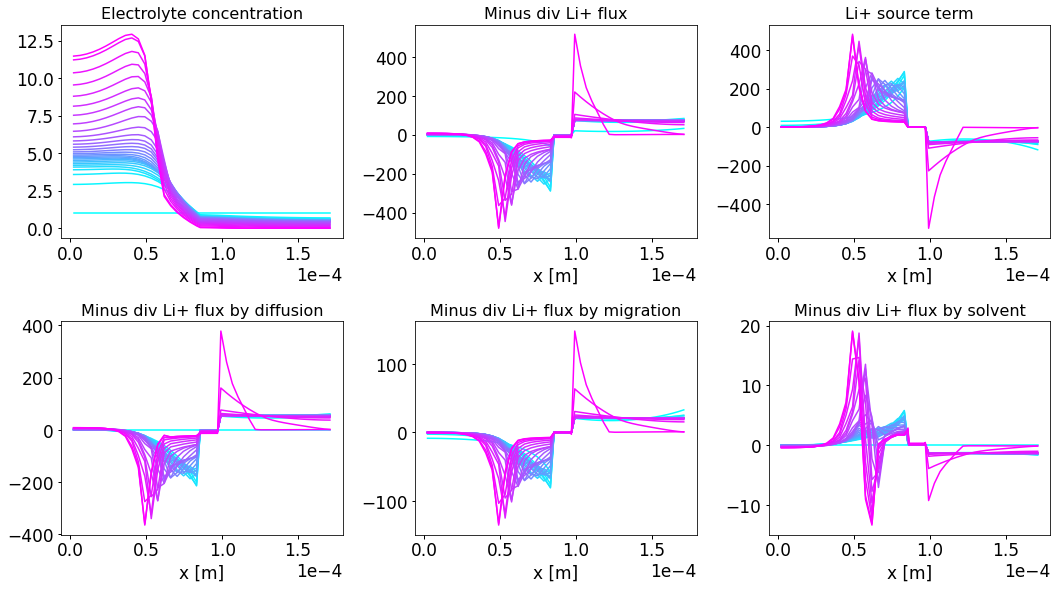

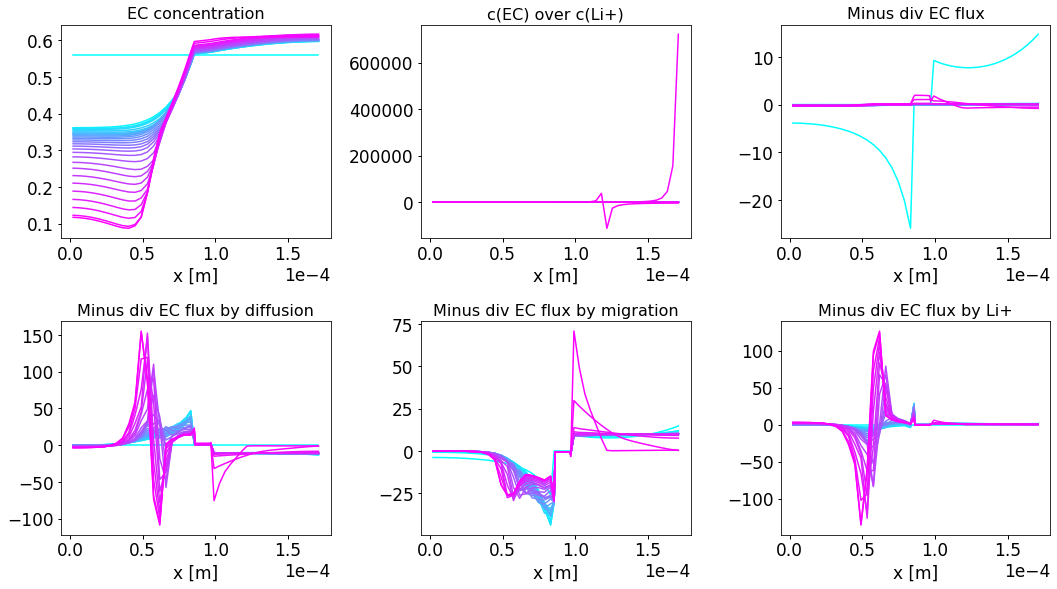

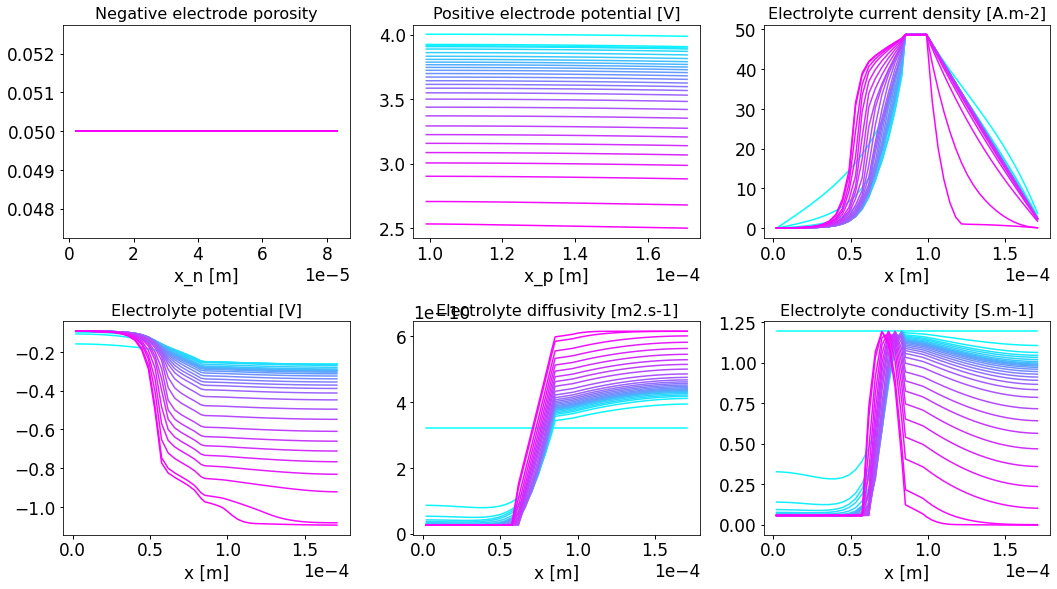

In [ ]:
Plot_Last_Single_Step(Sol_2,0,0,BasicPath, Target,1,1,'False',"cool",17,200)

Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29
Total line number is: 29


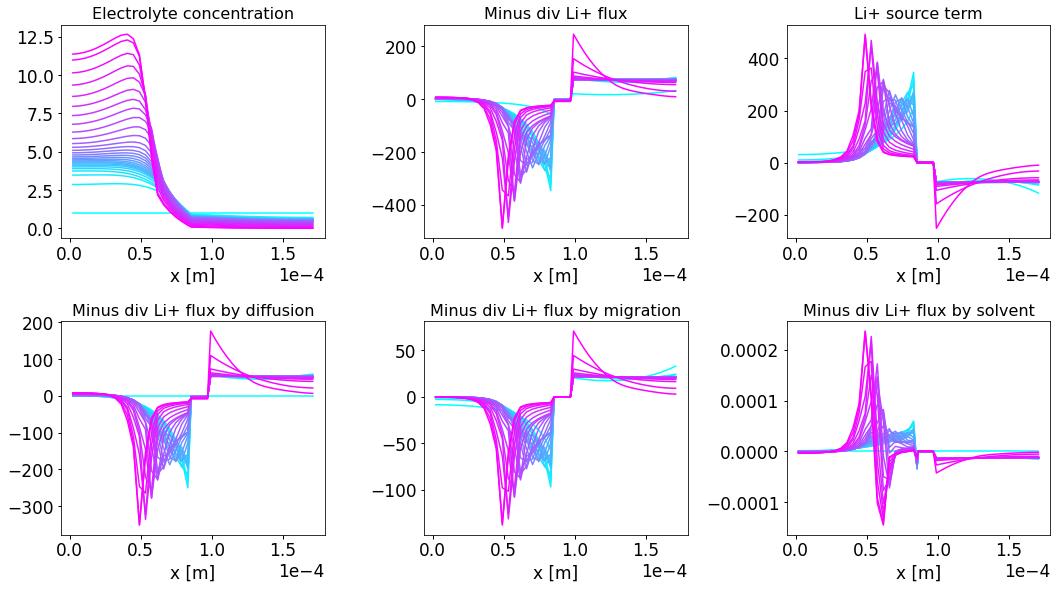

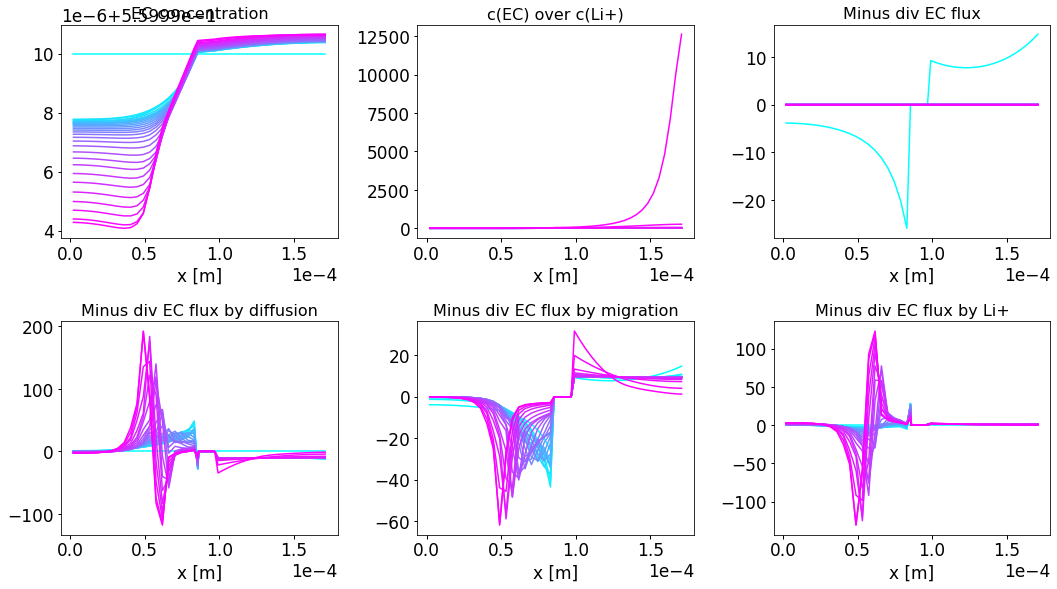

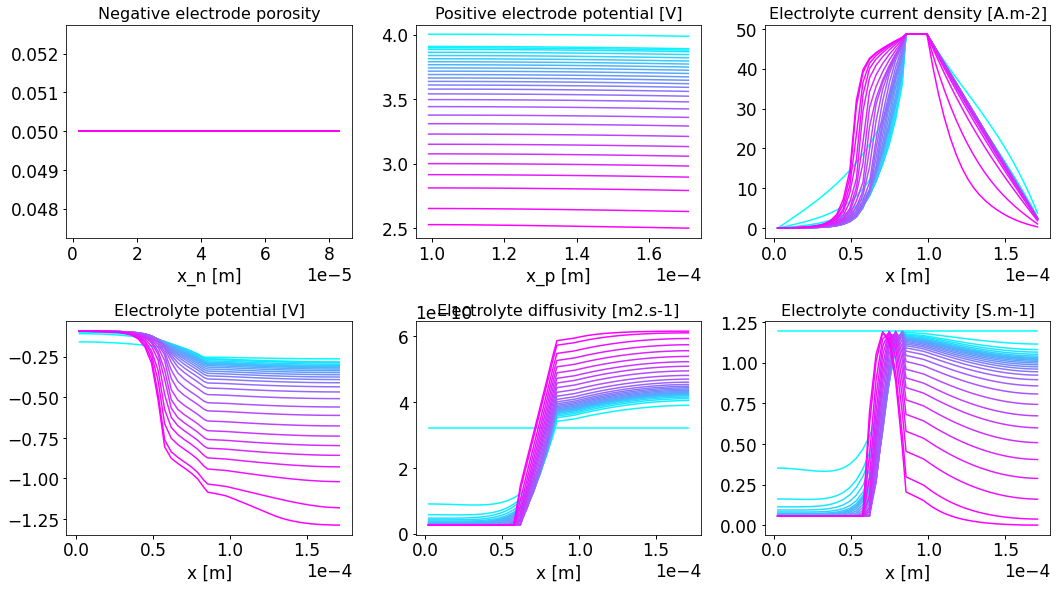

In [ ]:
Plot_Last_Single_Step(Sol_1,0,0,BasicPath, Target,1,1,'False',"cool",17,200)